In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
# sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

In [4]:
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 10]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

In [16]:
dataA2.shape[0] + dataA1.shape[0]

718597

篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [16]:
dist_dfA1.columns

Index(['發生月份', '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',
       '肇因研判大類別名稱-個別', '死亡', '受傷'],
      dtype='object')

In [5]:
dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']

car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_20557/3356275610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_20557/3356275610.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


In [6]:
from sklearn.utils import resample

sampling_ratio = 0.5

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

69
16727
70
16969
61
14787
55
13333
56
13575
61
14787
73
17696
67
16242
62
15030


In [7]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (139720, 159)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.229         6.66%                      6.66%
1              0.113         3.28%                      9.94%
2              0.107         3.11%                     13.05%
3              0.080         2.33%                     15.38%
4              0.074         2.17%                     17.54%
5              0.071         2.06%                     19.61%
6              0.070         2.03%                     21.63%
7              0.066         1.92%                     23.55%
8              0.061         1.78%                     25.33%
9              0.060         1.73%                     27.06%
10             0.052         1.52%                     28.58%


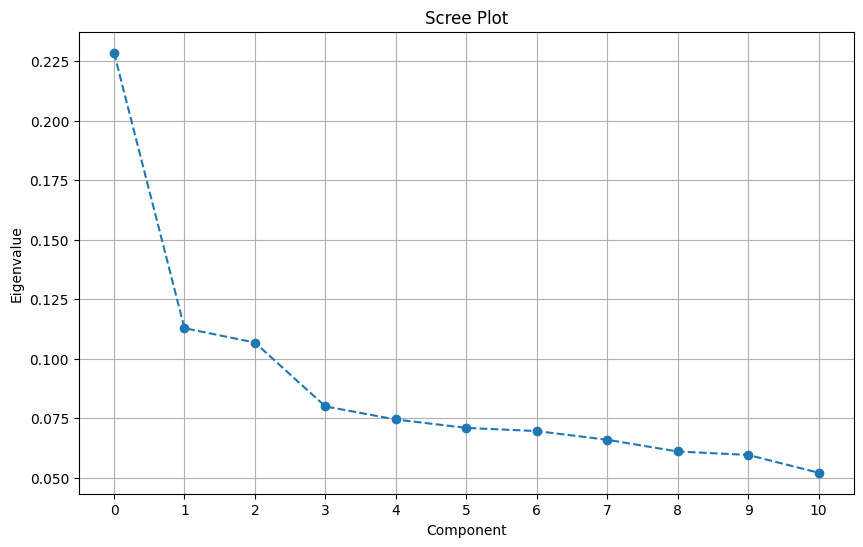

In [34]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=11,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [36]:
from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

In [37]:
import pickle

detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(6, 11):
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            # filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component6Undersample/results_o{overlap}i{interval}.pkl"
            filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 3, interval: 6


Processing Clusters: 100%|██████████| 57/57 [00:00<00:00, 57.80it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i6.pkl
overlap: 3, interval: 7


Processing Clusters: 100%|██████████| 78/78 [00:00<00:00, 88.76it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i7.pkl
overlap: 3, interval: 8


Processing Clusters: 100%|██████████| 86/86 [00:00<00:00, 106.37it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i8.pkl
overlap: 3, interval: 9


Processing Clusters: 100%|██████████| 121/121 [00:01<00:00, 65.46it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i9.pkl
overlap: 3, interval: 10


Processing Clusters: 100%|██████████| 151/151 [00:00<00:00, 159.81it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i10.pkl
overlap: 4, interval: 6


Processing Clusters: 100%|██████████| 43/43 [00:01<00:00, 36.54it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i6.pkl
overlap: 4, interval: 7


Processing Clusters: 100%|██████████| 53/53 [00:01<00:00, 49.46it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i7.pkl
overlap: 4, interval: 8


Processing Clusters: 100%|██████████| 67/67 [00:01<00:00, 38.64it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i8.pkl
overlap: 4, interval: 9


Processing Clusters: 100%|██████████| 86/86 [00:01<00:00, 78.95it/s] 


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i9.pkl
overlap: 4, interval: 10


Processing Clusters: 100%|██████████| 102/102 [00:01<00:00, 81.45it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i10.pkl
overlap: 5, interval: 6


Processing Clusters: 100%|██████████| 30/30 [00:01<00:00, 17.22it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i6.pkl
overlap: 5, interval: 7


Processing Clusters: 100%|██████████| 40/40 [00:02<00:00, 18.14it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i7.pkl
overlap: 5, interval: 8


Processing Clusters: 100%|██████████| 44/44 [00:02<00:00, 21.35it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i8.pkl
overlap: 5, interval: 9


Processing Clusters: 100%|██████████| 56/56 [00:02<00:00, 25.21it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i9.pkl
overlap: 5, interval: 10


Processing Clusters: 100%|██████████| 73/73 [00:01<00:00, 44.67it/s]


Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i10.pkl


In [40]:
detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_halfdata.csv", index=False)

output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/full_grid.pkl'
# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

In [41]:
detailed_results_df

,overlap,interval,silhouette,mapper_info
0,3,6,23.351150,"((0, 7, 3, 11, 75, 1, 8, 6, 9, 18, 12, 14, 27,..."
1,3,7,32.781195,"((0, 3, 31, 75, 6, 1, 4, 32, 55, 15, 72, 90, 1..."
2,3,8,24.753294,"((0, 3, 6, 25, 32, 117, 42, 79, 1, 24, 4, 55, ..."
3,3,9,23.830870,"((1, 55, 3, 43, 0, 49, 21, 27, 31, 48, 56, 73,..."
4,3,10,14.763933,"((0, 6, 44, 193, 3, 41, 11, 5, 29, 40, 108, 7,..."
5,4,6,36.892976,"((0, 5, 7, 4, 17, 40, 61, 1, 3, 8, 18, 60, 6, ..."
6,4,7,43.186336,"((0, 3, 11, 5, 85, 1, 4, 12, 24, 44, 27, 40, 7..."
7,4,8,46.254434,"((0, 3, 20, 27, 41, 53, 64, 5, 52, 89, 1, 54, ..."
8,4,9,32.903527,"((1, 3, 24, 139, 0, 4, 31, 138, 22, 34, 53, 55..."
9,4,10,30.686355,"((0, 17, 48, 64, 4, 60, 92, 9, 1, 3, 7, 12, 16..."


In [17]:
rbind_data.columns

Index(['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',
       '肇因研判大類別名稱-個別', '死亡', '受傷'],
      dtype='object')

In [8]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
sns.set(style="whitegrid", font=myfont.get_name())

from matplotlib.cm import get_cmap
from plots import *

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_90494/3460302972.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


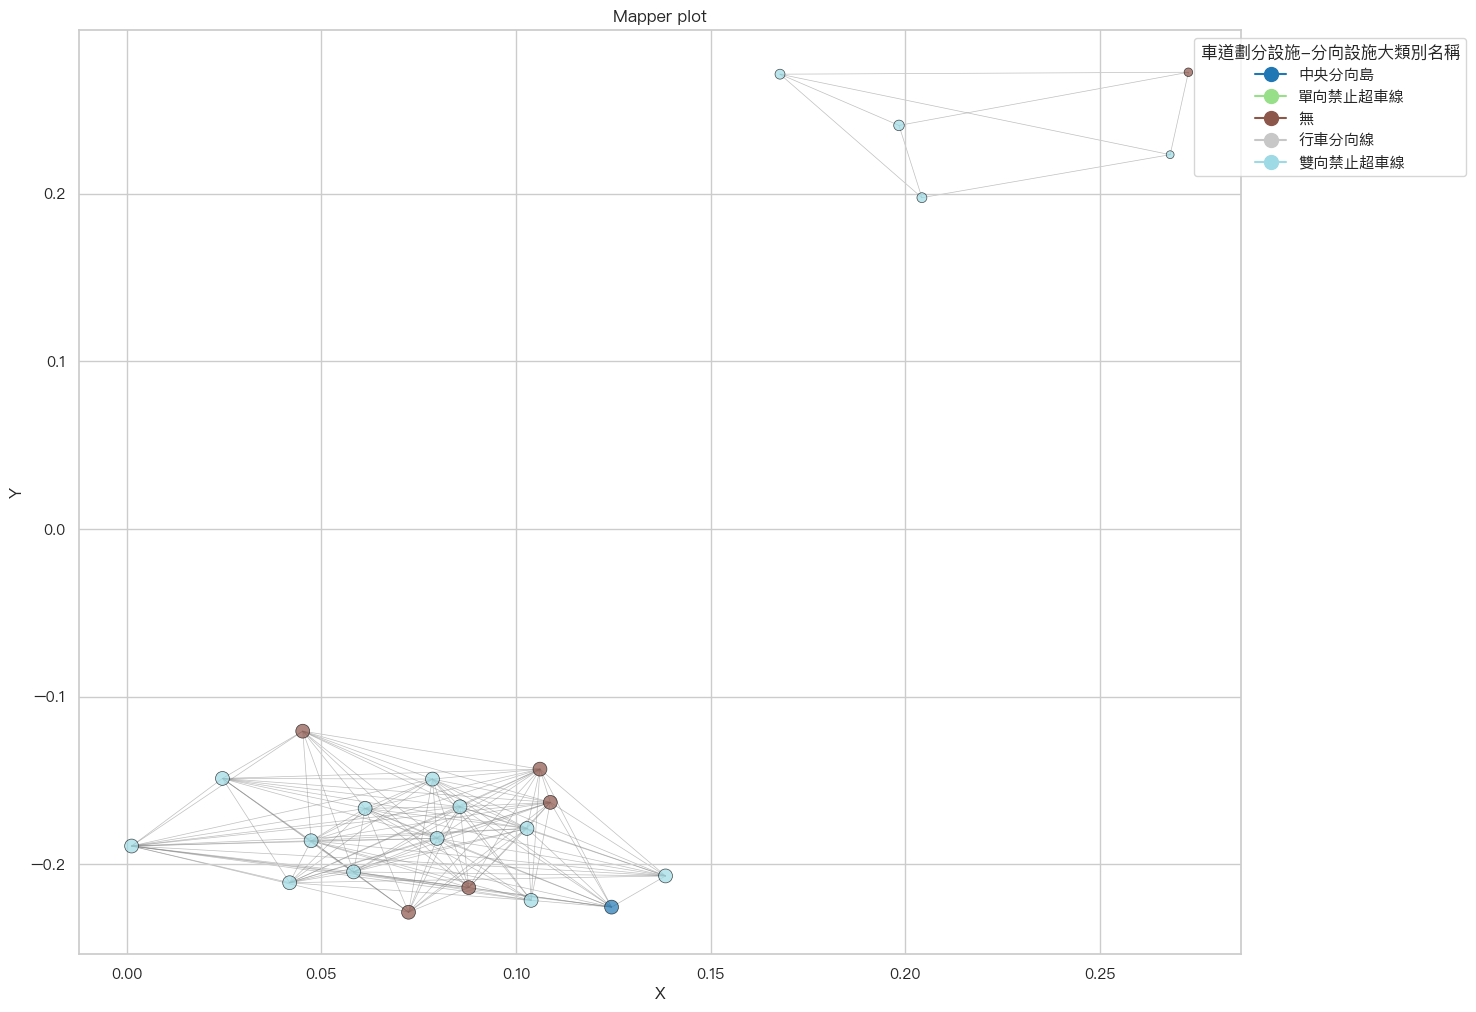

In [52]:
choose = '車道劃分設施-分向設施大類別名稱'
# choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[-2][0], 
                               rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=30)
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, set_label=True, size=100)

In [9]:
import umap
from umap import plot
import time

/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/wangqi

In [ ]:
reducer = umap.UMAP(
    n_jobs=-1, 
    n_neighbors=50, 
    min_dist=0.1, 
    n_components=2, 
    metric="hamming",
    # random_state=42
    )

lens1_umap = reducer.fit(mapper_numpy)
umap.plot.points(lens1_umap, labels=rbind_data['道路型態大類別名稱'])

n_neighbors越大越注重全局結構，5 到 50 ，5~15適合高維度<br/>
min_dist影響緊密程度，越大越稀疏，通常在0.0 到 0.5

In [ ]:
n_neighbors = [5, 15, 30, 50, 100]
min_dist_range = [0, 0.01, 0.05, 0.1, 0.5, 1]  # 0.1 to 0.5 inclusive with 5 steps

# for n_neighbors in n_neighbors_range:
for min_dist in min_dist_range:
    
    for n in n_neighbors:
        
        start_time = time.time()

        reducer = umap.UMAP(
            n_jobs=-1, 
            n_neighbors=n, 
            min_dist=min_dist, 
            n_components=2, 
            metric="hamming"
            )

        lens1_umap = reducer.fit(mapper_numpy)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)

        umap.plot.points(lens1_umap, labels=rbind_data['道路型態大類別名稱'])
        plt.savefig(f"Version3/GridSearch/UMAP/Car/UMAP_n{n}_d{min_dist:.2f}.png")

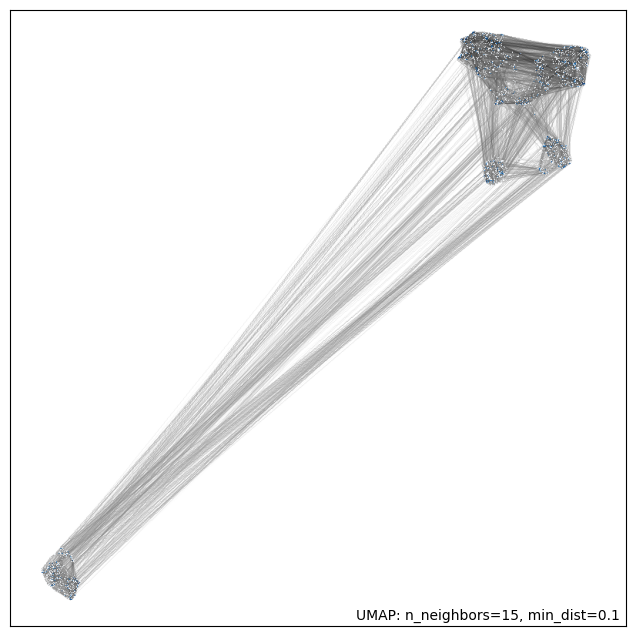

In [22]:
mapping = umap.UMAP().fit(mapper_numpy)

umap_plot = umap.plot.connectivity(mapping, show_points=True)